#### Load libraries

In [1]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio
import numpy as np
from typing import List

**Check and limit GPU usage**

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 1. Build Data Loading Functions

In [4]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url=url, output=output, quiet=False)
gdown.extractall(output)

**Data Loading Function**

In [5]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []

  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    
    # isolate mouth region
    frames.append(frame[190:236, 80:220, :])
  cap.release()

  # scaling data
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean), tf.float32) / std

In [6]:
# vocabulary for lip reading
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


***Kind of encoding the letters and numbers***

In [8]:
char_to_num(['a', 'm', 'i', 't'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 13,  9, 20], dtype=int64)>

In [9]:
num_to_char([ 1, 13,  9, 20])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'm', b'i', b't'], dtype=object)>

**Load alignments (labels)**

In [10]:
def load_alignments(path:str) -> List[str]:
  with open(path, 'r') as f:
    lines = f.readlines()
  
  tokens = []
  for line in lines:
    line = line.split()

    # ignore lines with silence
    if line[2] != 'sil':
      tokens = [*tokens, ' ', line[2]]
  
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

**Load video and alignments together**

In [11]:
def load_data(path:str):
  path = bytes.decode(path.numpy())

  file_name = path.split('\\')[-1].split('.')[0]
  video_path = os.path.join('data', 's1', f'{file_name}.mpg')
  alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

***Let's use a test sample***

In [12]:
test_sample = '.\\data\\s1\\bbaf2n.mpg'

In [ ]:
tf.convert_to_tensor(test_sample).numpy().decode().split('\\')[-1].split('.')[0]

'bbaf2n'

In [13]:
test_sample_process = load_data(tf.convert_to_tensor(test_sample))
test_sample_process

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4616871 ],
          [1.4616871 ],
          [1.4991663 ],
          ...,
          [0.3373124 ],
          [0.3373124 ],
          [0.3373124 ]],
 
         ...,
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.11243746],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.07495831],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.07495831],
    

In [14]:
num_of_frames, height, width, num_of_channels = test_sample_process[0].shape

print(f"No. of frames: {num_of_frames}\n"
      f"Dimensions of frame: {(height, width)}\n"
      f"No. of channels: {num_of_channels}")

No. of frames: 75
Dimensions of frame: (46, 140)
No. of channels: 1


In [15]:
frames, alignments = test_sample_process

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

***Check test frame***

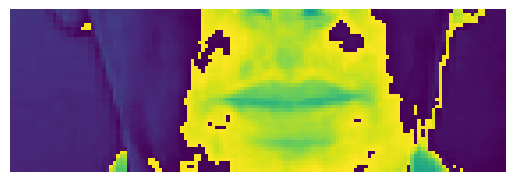

In [17]:
plt.axis('off')
plt.imshow(frames[21])
plt.show()

***Check test alignment***

In [18]:
test_alignments = [bytes.decode(x) for x in num_to_char(alignments).numpy()]
tf.strings.reduce_join(test_alignments).numpy().decode()

'bin blue at f two now'

In [19]:
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

#### 2. Build Data Pipeline

In [20]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [21]:
len(train)

450

In [22]:
len(test)

50

*After loading with list_files*

In [23]:
data.as_numpy_iterator().next()

(array([[[[[ 1.4919944 ],
           [ 1.4919944 ],
           [ 1.3772255 ],
           ...,
           [ 0.30605012],
           [ 0.26779386],
           [ 0.26779386]],
 
          [[ 1.5685068 ],
           [ 1.4919944 ],
           [ 1.3007131 ],
           ...,
           [ 0.30605012],
           [ 0.26779386],
           [ 0.26779386]],
 
          [[ 1.5302507 ],
           [ 1.5302507 ],
           [ 1.4919944 ],
           ...,
           [ 0.34430638],
           [ 0.30605012],
           [ 0.30605012]],
 
          ...,
 
          [[ 1.0711755 ],
           [ 1.0711755 ],
           [ 1.0711755 ],
           ...,
           [ 0.        ],
           [ 0.        ],
           [ 0.        ]],
 
          [[ 1.0329192 ],
           [ 1.0329192 ],
           [ 1.0329192 ],
           ...,
           [ 0.        ],
           [ 0.        ],
           [ 0.        ]],
 
          [[ 1.0329192 ],
           [ 1.0329192 ],
           [ 1.0329192 ],
           ...,
           [ 0

*After mapping the data*

In [ ]:
frames, alignments = data.as_numpy_iterator().next()
test_alignments = [bytes.decode(x) for x in num_to_char(alignments).numpy()]
print(tf.strings.reduce_join(test_alignments).numpy().decode())
plt.imshow(frames[0])
plt.show()

*After padding -> if few sentences are of different length 0 will be added to make all uniform*

In [29]:
frames, alignments = data.as_numpy_iterator().next()
alignments

array([[19,  5, 20, 40,  7, 18,  5,  5, 14, 40,  9, 14, 40,  9, 40, 20,
        23, 15, 40, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 40, 18,  5,  4, 40, 23,  9, 20,  8, 40,  7, 40, 19,
         5, 22,  5, 14, 40, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [30]:
len(frames)

2

***Let's visualize***

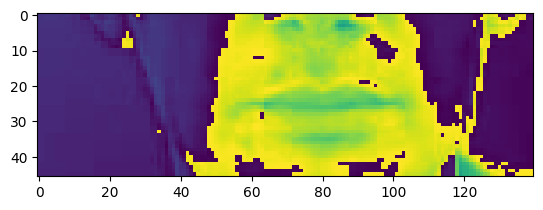

In [31]:
test_sample = data.as_numpy_iterator()
val = test_sample.next()
plt.imshow(val[0][1][0])
plt.show()

*Make a gif out of the video frames*

In [32]:
imageio.mimsave('./animation.gif', val[0][1])

Lossy conversion from float32 to uint8. Range [0.0, 9.66237735748291]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.66237735748291]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.66237735748291]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.66237735748291]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.66237735748291]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.66237735748291]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.66237735748291]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

#### 3. Design the Deep Learning Model

**Import dependencies**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0].shape

(2, 75, 46, 140, 1)

In [34]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

*Let's test our model for once*

In [36]:
yhat = model.predict(val[0])

1/1 [==============================] - 11s 11s/step


In [37]:
tf.argmax(yhat[0], axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10], dtype=int64)>

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]]).numpy().decode()

'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj'

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

#### 4. Setup Training Options and Train

In [41]:
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [43]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [45]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
example_callback = ProduceExample(data)

In [48]:
model.fit(data, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling3d_1/MaxPool3D/MaxPool3DGrad' defined at (most recent call last):
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dasam\AppData\Local\Temp\ipykernel_8932\2848841378.py", line 1, in <module>
      model.fit(data, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\dasam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/max_pooling3d_1/MaxPool3D/MaxPool3DGrad'
OOM when allocating tensor with shape[2,256,75,23,70] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/max_pooling3d_1/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_61492]